# Explanatory Data Analysis

## Questions to be answered

1. What is the relation between gender, age and occupation with crime committing? Has it changed over the years?
2. Is there a relation between the type of crimes committed and its victims?
3. Has the number of crimes increased or decreased over the century? If positive, by how much?
4. What are the most common crimes committed? And most common punishments? Have they changed over the years?
5. How do seasonal or monthly trends affect the data?

## Importing libraries and dataset


This section downloads the original XML data file from Old Bailey's court and unzips it inside the dataset/data directory.

The files are divided by date, on which multiple trials can be stored at once. A list ('xml_files') stores all the files' names and, later on, is iterated over, opening each file and collecting the relevant data about the trials with the funcion process_trials_on_file. The function goes through the XML file and register each trial inside it, gathering the data in dictionaries and storing them on a list.

The list is then converted to JSON for optimal storage of processed data, since the iteration through all files takes some considerate time.

In [41]:
import pandas as pd
import lxml
from lxml import etree
import os
import json
import wget
import unzip
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Download and unzip file
# UNHARDCODE PATH TEST
!wget https://orda.shef.ac.uk/ndownloader/articles/4775434/versions/2
!unzip 2 -d dataset
!unzip dataset/OBO_XML_7-2.zip -d dataset/data

--2025-01-21 18:13:33--  https://orda.shef.ac.uk/ndownloader/articles/4775434/versions/2
Resolving orda.shef.ac.uk (orda.shef.ac.uk)... 2a05:d018:1f4:d003:af1a:8116:f2e7:d5e9, 2a05:d018:1f4:d000:3f3e:dee3:afb0:cb4b, 54.77.156.78, ...
Connecting to orda.shef.ac.uk (orda.shef.ac.uk)|2a05:d018:1f4:d003:af1a:8116:f2e7:d5e9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315238180 (301M) [application/zip]
Saving to: '2'

     0K .......... .......... .......... .......... ..........  0% 78,5K 65m21s
    50K .......... .......... .......... .......... ..........  0%  235K 43m34s
   100K .......... .......... .......... .......... ..........  0% 89,8M 29m3s
   150K .......... .......... .......... .......... ..........  0%  236K 27m13s
   200K .......... .......... .......... .......... ..........  0%  130M 21m47s
   250K .......... .......... .......... .......... ..........  0%  115M 18m9s
   300K .......... .......... .......... .......... ..........  0%  237K 18m

Archive:  2
 extracting: dataset/OB_xml_notes.docx  
 extracting: dataset/OBO_XML_7-2.zip  
Archive:  dataset/OBO_XML_7-2.zip
  inflating: dataset/data/licence.txt  
  inflating: dataset/data/listOA.txt  
  inflating: dataset/data/listOBP.txt  
  inflating: dataset/data/OB_xml_notes.docx  
   creating: dataset/data/ordinarysAccounts/
  inflating: dataset/data/ordinarysAccounts/.DS_Store  
  inflating: dataset/data/ordinarysAccounts/OA16760517.xml  
  inflating: dataset/data/ordinarysAccounts/OA16760705.xml  
  inflating: dataset/data/ordinarysAccounts/OA16760830.xml  
  inflating: dataset/data/ordinarysAccounts/OA16761025.xml  
  inflating: dataset/data/ordinarysAccounts/OA16770316.xml  
  inflating: dataset/data/ordinarysAccounts/OA16770504.xml  
  inflating: dataset/data/ordinarysAccounts/OA16771017.xml  
  inflating: dataset/data/ordinarysAccounts/OA16771219.xml  
  inflating: dataset/data/ordinarysAccounts/OA16780123.xml  
  inflating: dataset/data/ordinarysAccounts/OA16780306.xml 

In [ ]:
# Creates a list with all xml file's names
folder_path = 'dataset\data\sessionsPapers'
xml_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.xml')]
xml_files

In [ ]:
# Gets trial's info from xml files and adds to list
def process_trials_on_file(tree, data_list):
    '''
    Extracts trial's info from each XML file in a dictionary and appends to a list.

    Args:
        tree: the parsed XML document tree.
        data_list: a list to store the trial's dictionaries.

    '''
    # finds date of all trials in file
    trial_date = tree.xpath('//div0//interp[@type="date"]/@value')
    trial_date = trial_date[0]

    # finds total number of trials in file
    trials_ids = tree.xpath('//div0//div1[@type="trialAccount"]/@id')
    num_trials = len(trials_ids)

    for trial in trials_ids:
        trial_defendant_gender = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//p//persName[@type="defendantName"]//interp[@type="gender"]/@value')
        trial_defendant_age = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//p//persName[@type="defendantName"]//interp[@type="age"]/@value')
        trial_defendant_occupation = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//p//persName[@type="defendantName"]//interp[@type="occupation"]/@value')
        trial_victim_gender = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//p//persName[@type="victimName"]//interp[@type="gender"]/@value')
        trial_verdict_category = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//rs[@type="verdictDescription"]//interp[@type="verdictCategory"]/@value')
        trial_verdict_subcategory = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//rs[@type="verdictDescription"]//interp[@type="verdictSubcategory"]/@value')
        trial_offence_category = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//rs[@type="offenceDescription"]//interp[@type="offenceCategory"]/@value')
        trial_offence_subcategory = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//rs[@type="offenceDescription"]//interp[@type="offenceSubcategory"]/@value')
        trial_punishment_category = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//p//rs[@type="punishmentDescription"]//interp[@type="punishmentCategory"]/@value')
        trial_punishment_subcategory = tree.xpath(f'//div0//div1[@type="trialAccount" and @id="{trial}"]//p//rs[@type="punishmentDescription"]//interp[@type="punishmentSubcategory"]/@value')


        data_list.append({
            "trial_id": trial,
            "trial_date": trial_date,
            "trial_defendant_gender": trial_defendant_gender,
            "trial_defendant_age": trial_defendant_age,
            "trial_defendant_occupation": trial_defendant_occupation,
            "trial_victim_gender": trial_victim_gender,
            "trial_verdict_category": trial_verdict_category,
            "trial_verdict_subcategory": trial_verdict_subcategory,
            "trial_offence_category": trial_offence_category,
            "trial_offence_subcategory": trial_offence_subcategory,
            "trial_punishment_category": trial_punishment_category,
            "trial_punishment_subcategory": trial_punishment_subcategory,
        })


In [ ]:
# Adds info on xml files to a list
def get_data_from_xml(file, data_list):
  tree = etree.parse(file)          # parses xml file

  process_trials_on_file(tree, data_list)      # extracts info

In [ ]:
trials_data = []                  # creates list

# Iterates through all existing trial's files
for file in xml_files:

  get_data_from_xml(file, trials_data)

In [ ]:
def save_to_json(data, file_name):
    with open(file_name, 'w') as f:
        json.dump(data, f)

save_to_json(trials_data, 'extracted_data.json')

## Processing dataset

In [2]:
# Use this cell to import data directly from JSON file
trials_data = []

# Gets JSON file
with open("extracted_data.json") as json_file:
    trials_data = json.load(json_file)

In [3]:
df = pd.DataFrame(trials_data)

In [4]:
# The mask function replaces (lists that are of false boolean value) and (elements of value [''] or ['indeterminate'])
df_wnan = df.mask((df.map(type).eq(list) & ~df.astype(bool)) | (df.map(lambda x: (x == [''] or x == ['indeterminate']))), other=np.nan)

In [5]:
df_wnan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197751 entries, 0 to 197750
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   trial_id                      197751 non-null  object
 1   trial_date                    197751 non-null  object
 2   trial_defendant_gender        197627 non-null  object
 3   trial_defendant_age           119297 non-null  object
 4   trial_defendant_occupation    7013 non-null    object
 5   trial_victim_gender           165658 non-null  object
 6   trial_verdict_category        197445 non-null  object
 7   trial_verdict_subcategory     107907 non-null  object
 8   trial_offence_category        197695 non-null  object
 9   trial_offence_subcategory     197695 non-null  object
 10  trial_punishment_category     146132 non-null  object
 11  trial_punishment_subcategory  89033 non-null   object
dtypes: object(12)
memory usage: 18.1+ MB


In [8]:
df_wnan['trial_date']

0         16740429
1         16740429
2         16740429
3         16740429
4         16740429
            ...   
197746    19130401
197747    19130401
197748    19130401
197749    19130401
197750    19130401
Name: trial_date, Length: 197751, dtype: object

In [9]:
# Timestamps that marked before 1677 were replaced as NaT
df_wnan['trial_date'] = pd.to_datetime(df_wnan['trial_date'], format='%Y%m%d', errors="coerce")

df_wnan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197751 entries, 0 to 197750
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   trial_id                      197751 non-null  object        
 1   trial_date                    197522 non-null  datetime64[ns]
 2   trial_defendant_gender        197627 non-null  object        
 3   trial_defendant_age           119297 non-null  object        
 4   trial_defendant_occupation    7013 non-null    object        
 5   trial_victim_gender           165658 non-null  object        
 6   trial_verdict_category        197445 non-null  object        
 7   trial_verdict_subcategory     107907 non-null  object        
 8   trial_offence_category        197695 non-null  object        
 9   trial_offence_subcategory     197695 non-null  object        
 10  trial_punishment_category     146132 non-null  object        
 11  trial_punishm

## Has the number of crimes increased or decreased over the century? If positive, by how much?

In [10]:
df_wnan.tail(5)

,trial_id,trial_date,trial_defendant_gender,trial_defendant_age,trial_defendant_occupation,trial_victim_gender,trial_verdict_category,trial_verdict_subcategory,trial_offence_category,trial_offence_subcategory,trial_punishment_category,trial_punishment_subcategory
197746,t19130401-63,1913-04-01,[male],[45],[clicker],[female],[guilty],[pleadedGuilty],[breakingPeace],[wounding],[imprison],[hardLabour]
197747,t19130401-64,1913-04-01,[male],[24],[labourer],NaN,[guilty],[no_subcategory],[sexual],[rape],[imprison],[hardLabour]
197748,t19130401-65,1913-04-01,"[male, male]","[24, 18]",NaN,[male],[notGuilty],[noEvidence],[kill],[manslaughter],NaN,NaN
197749,t19130401-66,1913-04-01,[male],[17],[labourer],NaN,[guilty],[no_subcategory],[sexual],[sodomy],[imprison],[otherInstitution]
197750,t19130401-67,1913-04-01,[female],[53],NaN,NaN,[guilty],[withRecommendation],[damage],[other],[imprison],[penalServitude]


In [38]:
df_wnan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197751 entries, 0 to 197750
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   trial_id                      197751 non-null  object        
 1   trial_date                    197522 non-null  datetime64[ns]
 2   trial_defendant_gender        197627 non-null  object        
 3   trial_defendant_age           119297 non-null  object        
 4   trial_defendant_occupation    7013 non-null    object        
 5   trial_victim_gender           165658 non-null  object        
 6   trial_verdict_category        197445 non-null  object        
 7   trial_verdict_subcategory     107907 non-null  object        
 8   trial_offence_category        197695 non-null  object        
 9   trial_offence_subcategory     197695 non-null  object        
 10  trial_punishment_category     146132 non-null  object        
 11  trial_punishm

In [26]:
df_wnan['trial_month'] = df_wnan['trial_date'].dt.month.convert_dtypes(convert_integer=True)

In [28]:
df_wnan['trial_year'] = df_wnan['trial_date'].dt.year.convert_dtypes(convert_integer=True)

In [37]:
df_wnan['trial_day'] = df_wnan['trial_date'].dt.day.convert_dtypes(convert_integer=True)

In [30]:
df_wnan['trial_month'].value_counts().sort_values(ascending=True)

trial_month
3      5811
8      9099
11     9775
6     14123
7     14834
12    17690
5     17996
1     19416
2     20381
10    20447
4     22642
9     25308
Name: count, dtype: Int64


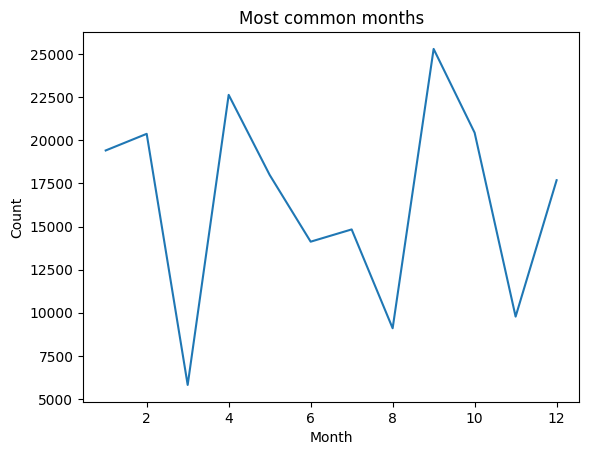

In [59]:
value_counts_month = df_wnan['trial_month'].value_counts().sort_index()
plt.plot(value_counts_month.index, value_counts_month.values)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Most common months')
plt.show()

In [33]:
df_wnan['trial_year'].value_counts().sort_values(ascending=True)

trial_year
1706       1
1677      25
1702      69
1703      72
1709      99
        ... 
1838    2718
1841    2791
1839    2822
1842    3090
1843    3100
Name: count, Length: 235, dtype: Int64

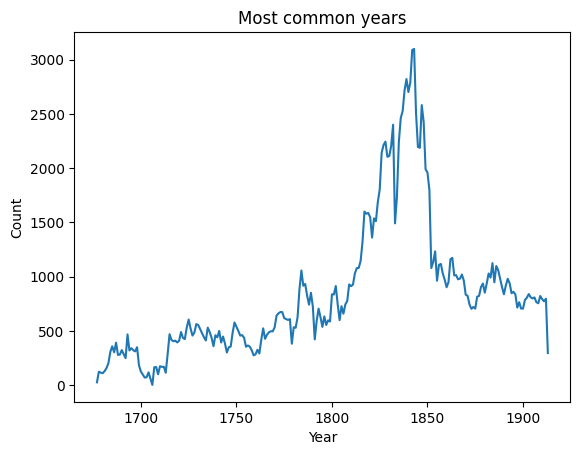

In [58]:
value_counts_year = df_wnan['trial_year'].value_counts().sort_index()
plt.plot(value_counts_year.index, value_counts_year.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Most common years')
plt.show()

In [39]:
df_wnan['trial_day'].value_counts().sort_values(ascending=True)

trial_day
31    2393
29    4305
30    4340
1     4413
24    4507
22    5011
19    5379
26    5502
25    5507
21    5530
27    5570
20    5577
2     5640
23    5708
18    6577
13    6628
4     6687
28    6707
5     6716
7     6719
9     6749
3     7457
8     7628
12    7720
17    7793
6     7815
10    8065
11    8486
14    8567
16    8776
15    9050
Name: count, dtype: Int64

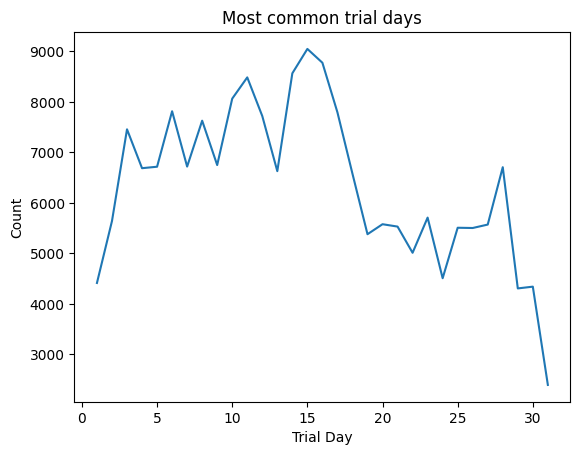

In [54]:
value_counts_days = df_wnan['trial_day'].value_counts().sort_index()
plt.plot(value_counts_days.index, value_counts_days.values)
plt.xlabel('Trial Day')
plt.ylabel('Count')
plt.title('Most common trial days')
plt.show()
